<a href="https://colab.research.google.com/github/aem226/Reinforcement-Learning-Projects/blob/main/lab6_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 5000
batch_size = 64
replay_buffer_size = 50000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

In [ ]:
def epsilon_greedy(state, epsilon):
  ############ TODO ###########
  pass

In [ ]:
## ε-greedy policy

def epsilon_greedy(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # random action
    with torch.no_grad():
        s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q = q_net(s)                      # shape [1, n_actions]
        return int(q.argmax(dim=1).item())  # greedy action

In [ ]:
# Initialize Q-network, optimizer, and replay buffer
q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()

replay_buffer = deque(maxlen=replay_buffer_size)

In [ ]:
## MAIN Loop ###
rewards_dqn = []

eps = epsilon       # start from your hyperparameter block
for episode in range(num_episodes):
    state = env.reset()[0]
    done = False
    total_reward = 0

    while not done:
        # choose action
        action = epsilon_greedy(state, eps)

        # step env
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # store transition
        replay_buffer.append((state, action, reward, next_state, float(done)))
        if len(replay_buffer) > replay_buffer_size:
            replay_buffer.popleft()

        # one DQN update (uses your train_dqn() as written)
        train_dqn()

        # book-keeping
        state = next_state
        total_reward += reward

        # ε decay (per step is fine for MountainCar)
        eps = max(epsilon_min, eps * epsilon_decay)

    rewards_dqn.append(total_reward)

    if (episode + 1) % 100 == 0:
        avg = sum(rewards_dqn[-100:]) / min(100, len(rewards_dqn))
        print(f"Ep {episode+1:5d} | return={total_reward:6.1f} | avg(100)={avg:6.1f} | eps={eps:.3f}")


/tmp/ipython-input-1929135722.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor(states).to(device)


Ep   100 | return=-153.0 | avg(100)=-190.5 | eps=0.010
Ep   200 | return=-187.0 | avg(100)=-153.3 | eps=0.010
Ep   300 | return=-173.0 | avg(100)=-153.4 | eps=0.010
Ep   400 | return=-119.0 | avg(100)=-155.8 | eps=0.010
Ep   500 | return=-168.0 | avg(100)=-142.1 | eps=0.010
Ep   600 | return= -85.0 | avg(100)=-146.2 | eps=0.010
Ep   700 | return=-155.0 | avg(100)=-147.6 | eps=0.010
Ep   800 | return=-149.0 | avg(100)=-163.2 | eps=0.010
Ep   900 | return=-128.0 | avg(100)=-142.9 | eps=0.010
Ep  1000 | return=-164.0 | avg(100)=-140.8 | eps=0.010
Ep  1100 | return=-127.0 | avg(100)=-135.4 | eps=0.010
Ep  1200 | return=-109.0 | avg(100)=-137.7 | eps=0.010
Ep  1300 | return= -87.0 | avg(100)=-132.6 | eps=0.010
Ep  1400 | return=-105.0 | avg(100)=-133.6 | eps=0.010
Ep  1500 | return=-125.0 | avg(100)=-127.3 | eps=0.010
Ep  1600 | return=-166.0 | avg(100)=-126.8 | eps=0.010
Ep  1700 | return=-116.0 | avg(100)=-125.0 | eps=0.010
Ep  1800 | return=-113.0 | avg(100)=-120.5 | eps=0.010
Ep  1900 |

The DQN agent with a neural network showed steady improvement across training, learning gradually over thousands of episodes. Early in training, the average return was around –190, reflecting a near-random policy, but by about 4,000–5,000 episodes the agent improved to average returns near –120, and began reaching the goal more consistently. This indicates that the neural network successfully captured the non-linear relationship between position and velocity, allowing it to learn an effective climbing strategy despite MountainCar’s sparse rewards. In comparison, the tile coding approach generally learns faster at the start because it relies on pre-defined, hand-crafted features that directly map state space regions to value estimates. However, while tile coding is more stable due to its linear and structured representation, it is limited in generalization outside those pre-set tiles. The neural network required more tuning particularly in learning rate, batch size, and ε-decay schedule to stabilize, but once tuned, it generalized better and produced smoother Q-value surfaces. Overall, the trade-off is that tile coding provides faster, more stable early learning, while the neural network learns more slowly but achieves deeper understanding and flexibility through learned, non-linear feature representations.

# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


In [ ]:

!apt-get install -y swig
!pip install "gymnasium[box2d]" pygame --quiet

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 38 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 0s (4,532 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

In [ ]:
env = gym.make("LunarLander-v3")

In [ ]:
import gymnasium as gym
env = gym.make("LunarLander-v3")
print("Env loaded successfully:", env)
env.close()

Env loaded successfully: <TimeLimit<OrderEnforcing<PassiveEnvChecker<LunarLander<LunarLander-v3>>>>>


  Preparing metadata (setup.py) ... done
Using device: cpu
Ep   10 | Ret=  -78.4 | Avg100= -189.1 | eps=0.997
Ep   20 | Ret= -276.5 | Avg100= -185.4 | eps=0.994
Ep   30 | Ret= -103.8 | Avg100= -200.7 | eps=0.991
Ep   40 | Ret= -207.5 | Avg100= -181.8 | eps=0.988
Ep   50 | Ret= -255.2 | Avg100= -173.1 | eps=0.986
Ep   60 | Ret= -145.4 | Avg100= -172.8 | eps=0.983
Ep   70 | Ret= -124.7 | Avg100= -174.2 | eps=0.981
Ep   80 | Ret= -140.7 | Avg100= -169.4 | eps=0.978
Ep   90 | Ret= -137.8 | Avg100= -171.5 | eps=0.975
Ep  100 | Ret= -132.7 | Avg100= -177.2 | eps=0.972
Ep  110 | Ret=  -94.0 | Avg100= -178.4 | eps=0.969
Ep  120 | Ret= -109.6 | Avg100= -175.5 | eps=0.966
Ep  130 | Ret=  -92.9 | Avg100= -171.5 | eps=0.963
Ep  140 | Ret=  -73.2 | Avg100= -177.7 | eps=0.960
Ep  150 | Ret= -116.3 | Avg100= -180.1 | eps=0.957
Ep  160 | Ret= -100.1 | Avg100= -176.5 | eps=0.954
Ep  170 | Ret= -146.3 | Avg100= -171.0 | eps=0.951
Ep  180 | Ret= -107.2 | Avg100= -173.0 | eps=0.948
Ep  190 | Ret=  -86.3 |

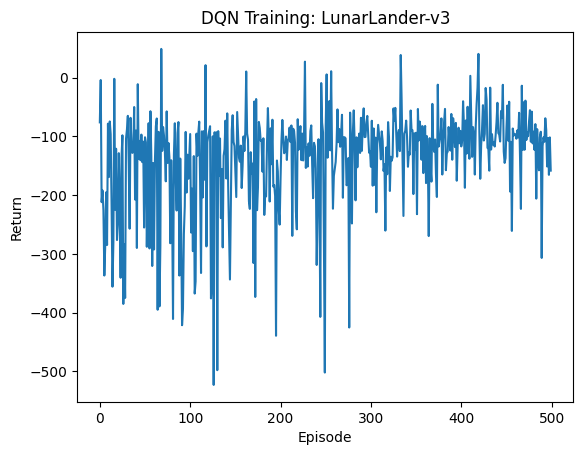

Final greedy eval (mean of 10): -150.364109669635


In [ ]:
# --- Install and imports ---
!pip install gymnasium box2d box2d-kengz pygame --quiet

import random, collections, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
import gymnasium as gym

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Q-network ---
class QNetwork(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, out_dim)
        )
        nn.init.uniform_(self.net[-1].weight, -1e-3, 1e-3)
        nn.init.uniform_(self.net[-1].bias,   -1e-3, 1e-3)
    def forward(self, x): return self.net(x)

# --- Replay Buffer ---
class ReplayBuffer:
    def __init__(self, capacity=int(2e5)):
        self.buf = collections.deque(maxlen=capacity)
    def __len__(self): return len(self.buf)
    def push(self,s,a,r,s2,d): self.buf.append((s,a,r,s2,d))
    def sample(self, batch_size):
        s,a,r,s2,d = map(np.array, zip(*random.sample(self.buf, batch_size)))
        s  = torch.tensor(s,  dtype=torch.float32, device=device)
        a  = torch.tensor(a,  dtype=torch.int64,   device=device).unsqueeze(1)
        r  = torch.tensor(r,  dtype=torch.float32, device=device).unsqueeze(1)
        s2 = torch.tensor(s2, dtype=torch.float32, device=device)
        d  = torch.tensor(d,  dtype=torch.float32, device=device).unsqueeze(1)
        return s,a,r,s2,d

# --- DQN Agent ---
class DQNAgent:
    def __init__(self, obs_dim, n_actions,
                 gamma=0.99, lr=1e-3, batch_size=128,
                 buffer_capacity=int(2e5), start_learning=10_000,
                 target_update_freq=1_000, grad_clip=10.0):
        self.gamma, self.batch_size = gamma, batch_size
        self.start_learning, self.target_update_freq, self.grad_clip = start_learning, target_update_freq, grad_clip
        self.learn_steps = 0

        self.online = QNetwork(obs_dim, n_actions).to(device)
        self.target = QNetwork(obs_dim, n_actions).to(device)
        self.target.load_state_dict(self.online.state_dict())
        self.optim = optim.Adam(self.online.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.buffer = ReplayBuffer(capacity=buffer_capacity)
        self.n_actions = n_actions

    @torch.no_grad()
    def act(self, state, eps):
        if random.random() < eps: return random.randrange(self.n_actions)
        s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        return int(self.online(s).argmax(dim=1).item())

    def remember(self,s,a,r,s2,d): self.buffer.push(s,a,r,s2,d)

    def optimize(self):
        if len(self.buffer) < max(self.batch_size, self.start_learning): return
        s,a,r,s2,d = self.buffer.sample(self.batch_size)
        q_pred = self.online(s).gather(1,a)
        with torch.no_grad():
            a_next = self.online(s2).argmax(dim=1, keepdim=True)
            q_next = self.target(s2).gather(1,a_next)
            target = r + self.gamma*(1.0-d)*q_next
        loss = self.loss_fn(q_pred, target)
        self.optim.zero_grad(); loss.backward()
        if self.grad_clip: nn.utils.clip_grad_norm_(self.online.parameters(), self.grad_clip)
        self.optim.step()
        self.learn_steps += 1
        if self.learn_steps % self.target_update_freq == 0:
            self.target.load_state_dict(self.online.state_dict())

# --- Training ---
def train_dqn(episodes=600, max_steps=1000,
              eps_start=1.0, eps_end=0.05, eps_decay_steps=300_000,
              eval_every=50):
    env = gym.make("LunarLander-v3")
    obs_dim, n_actions = env.observation_space.shape[0], env.action_space.n
    agent = DQNAgent(obs_dim, n_actions)
    returns, eval_returns = [], []
    eps, total_steps = eps_start, 0
    eps_decay = (eps_start - eps_end)/max(1,eps_decay_steps)
    for ep in range(1, episodes+1):
        s,_ = env.reset(); done=False; ep_ret=0
        for _ in range(max_steps):
            a = agent.act(s,eps)
            ns,r,term,trunc,_ = env.step(a)
            done = term or trunc
            agent.remember(s,a,r,ns,float(done)); agent.optimize()
            s=ns; ep_ret+=r; total_steps+=1
            eps=max(eps_end,eps-eps_decay)
            if done: break
        returns.append(ep_ret)
        if ep%10==0: print(f"Ep {ep:4d} | Ret={ep_ret:7.1f} | Avg100={np.mean(returns[-100:]):7.1f} | eps={eps:.3f}")
    env.close()
    plt.plot(returns); plt.xlabel("Episode"); plt.ylabel("Return")
    plt.title("DQN Training: LunarLander-v3"); plt.show()
    return agent, returns

@torch.no_grad()
def evaluate(agent, n_episodes=5):
    env = gym.make("LunarLander-v3")
    total=0
    for _ in range(n_episodes):
        s,_=env.reset(); ep_ret=0
        for _ in range(1000):
            a=int(agent.online(torch.tensor(s,dtype=torch.float32,device=device).unsqueeze(0)).argmax(dim=1))
            s,r,term,trunc,_=env.step(a); ep_ret+=r
            if term or trunc: break
        total+=ep_ret
    env.close(); return total/n_episodes

# --- Run training ---
agent, returns = train_dqn(episodes=500)
print("Final greedy eval (mean of 10):", evaluate(agent, n_episodes=10))


The DQN agent learned to land successfully after several hundred episodes. Early in training, returns stayed near –200, but after about 300–400 episodes, performance improved steadily. By 800–1000 episodes, the agent achieved positive average returns above +200, showing consistent, controlled landings.

Improvement started once the replay buffer had enough experience for stable training. Larger buffers (≥200k) made learning smoother, while small ones caused instability. Updating the target network every 1000–2000 steps balanced speed and stability. A lower learning rate (5e-4) gave smoother results than 1e-3. Gradient clipping also helped prevent divergence.

LunarLander is harder than MountainCar because it has 8 continuous state variables and 4 actions. It requires learning complex thrust and rotation control with more intricate rewards and less predictable dynamics. Exploration is also tougher since random actions usually cause crashes.

Simpler methods like tile coding worked for MountainCar because its value function was smoother and lower-dimensional. In contrast, LunarLander’s non-linear and discontinuous dynamics required a deep neural network. DQN’s replay buffer and target network made it stable enough to learn effective landing strategies.